# Basic stochastic volatility model

This note runs a stochastic volatility model with an AR(1) latent process.

$$y_t = \epsilon_t, \quad \epsilon_t \sim N_{0,(\lambda + \sigma b)^2}, \quad t=1,\dots,\tau$$
$$b_t = \psi b_{t-1} + \nu_t\quad \nu_t \sim N_{0,1}, \quad t=2,\dots,\tau$$
$$b_1 \sim N_{0, (1+\rho^2)^{-1/2}} $$

See the graphs below and code for information about the priors and inference, which is a structured (full-rank) VI procedure.

## Preliminaries

In [1]:
# !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl >/dev/null && echo OK
# !pip3 uninstall -y ptvi >/dev/null && echo OK
# !pip3 install git+https://github.com/kuperov/ptvi.git  >/dev/null && echo OK

In [1]:
from ptvi import *
import torch
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('precision', 2)
plt.rcParams['figure.figsize'] = [12, 8]

Define the true parameter values and generate data.

In [2]:
λ0, σ0, φ0 = 0., .75, 0.95
data_seed, algo_seed = 123, 123

In [4]:
torch.manual_seed(data_seed)
params = {'λ': λ0, 'σ': σ0, 'φ': φ0}
model = StochVolModel(input_length=100)
y, b = model.simulate(**params)

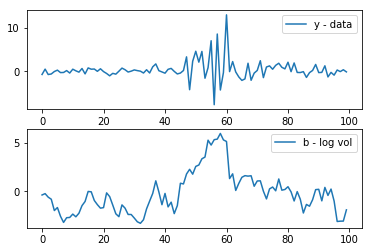

In [5]:
plt.subplot(211); plt.plot(y.numpy(), label='y - data'); plt.legend()
plt.subplot(212); plt.plot(b.numpy(), label='b - log vol'); plt.legend();

## Approximate inference


In [9]:
torch.manual_seed(algo_seed)
ζ0 = torch.cat([torch.zeros(100), torch.tensor([1., 1.])])
map_fit = map(model, y, ζ0=ζ0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
MAP inference with L-BGFS: Stochastic volatility model
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. log joint = -447.7612
       1. log joint = -177.8754
       2. log joint = -176.0075
       3. log joint = -176.0075
Convergence criterion met.
       3. log joint = -176.0075
Completed 4 iterations in 0.15s @ 27.21 i/s.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [12]:
u0, L0 = map_fit.initial_conditions()
fit = sgvb(model, y, u0=u0, L0=L0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Structured SGVB Inference for Stochastic volatility model:
  - Estimating elbo with M=1;
  - Stop on no improvement (skip=1, patience=10, min_steps=100, ε=0.01, α=0.1)
  - Adadelta optimizer with param groups:
    group 0. lr=1.0, rho=0.9, eps=1e-06, weight_decay=0
  - Displayed loss is smoothed with λ=0.1
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
       0. smoothed elbo = -417.27
       1. smoothed elbo = -420.38
       2. smoothed elbo = -415.38
       4. smoothed elbo = -421.82
       8. smoothed elbo = -411.97
      16. smoothed elbo = -738.88
      32. smoothed elbo = -885.94
      64. smoothed elbo =-1206.21
     128. smoothed elbo = -548.59
     256. smoothed elbo = -399.70
     512. smoothed elbo = -364.68
    1024. smoothed elbo = -294.03
    2048. smoothed elbo = -233.18
    4096. smoothed elbo = -179.83
    8192. smoothed elbo = -176.73
   16384. smoothed e

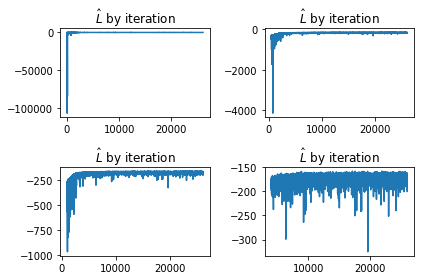

In [13]:
plt.subplot(221); fit.plot_elbos()
plt.subplot(222); fit.plot_elbos(skip=500)
plt.subplot(223); fit.plot_elbos(skip=1_000)
plt.subplot(224); fit.plot_elbos(skip=4_000)
plt.tight_layout()

In [8]:
fit.summary()

,mean,sd
σ,0.68,0.13
φ,0.88,0.05


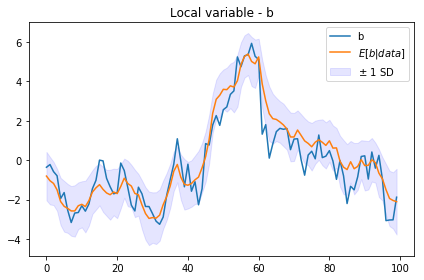

In [14]:
fit.plot_latent(b=b)

## Global variables: marginal posteriors

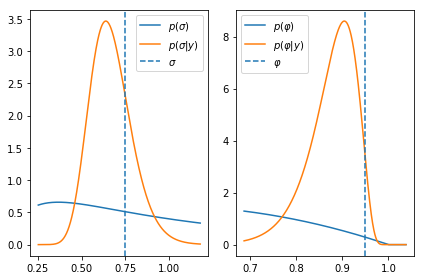

In [15]:
fit.plot_global_marginals(**params)

### Forecasts

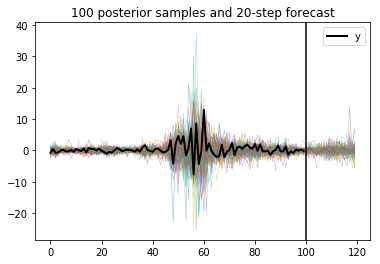

In [16]:
fit.plot_sample_paths(N=100, true_y=y, fc_steps=20)

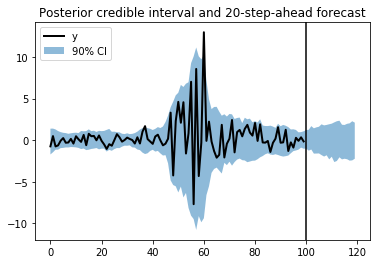

In [17]:
fit.plot_pred_ci(N=500, α=.1, true_y=y, fc_steps=20)